In [ ]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid,save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28),fpath=""):
    """
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid , save some results to disk
    """
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if len(fpath):
      save_image(image_unflat[:10],fpath,nrows=5,nromalize=True)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
class Generator(nn.Module):
    """
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
        normalization: whether to use batchnorm or not
    """
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128,normalization=None):
        super(Generator, self).__init__()
        self.norm = normalization
        self.gen = nn.Sequential(
            self._get_generator_block(z_dim, hidden_dim),
            self._get_generator_block(hidden_dim, hidden_dim * 2),
            self._get_generator_block(hidden_dim * 2, hidden_dim * 4),
            self._get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        """
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        """
        return self.gen(noise)

    def _get_generator_block(self, input_dim, output_dim):
        """
        Function for returning a block of the generator's neural network
        given input and output dimensions.
        Parameters:
            input_dim: the dimension of the input vector, a scalar
            output_dim: the dimension of the output vector, a scalar
        Returns:
            a generator neural network layer, with a linear transformation 
              followed by a batch normalization and then a relu activation
        """
        layers = [nn.Linear(input_dim, output_dim)]
        if self.norm == "batch":
          layers.append(nn.BatchNorm1d(output_dim))

        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers) 

In [ ]:
class Discriminator(nn.Module):
    """
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    """
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self._get_discriminator_block(im_dim, hidden_dim * 4),
            self._get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            self._get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        """
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        """
        return self.disc(image)


    def _get_discriminator_block(self, input_dim, output_dim):
        """
        Discriminator Block
        Function for returning a neural network of the discriminator given input and output dimensions.
        Parameters:
            input_dim: the dimension of the input vector, a scalar
            output_dim: the dimension of the output vector, a scalar
        Returns:
            a discriminator neural network layer, with a linear transformation 
              followed by an nn.LeakyReLU activation with negative slope of 0.2 
        """
        return nn.Sequential(
            nn.Linear(input_dim, output_dim), 
            nn.LeakyReLU(0.2, inplace=True))

In [ ]:
def weights_init(m):
  """
  Function to initialize the weights to the normal distribution
  with mean 0 and standard deviation 0.02
  """
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias, 0)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    """
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    """
    return torch.randn(n_samples,z_dim,device=device)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    """
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    """
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    """
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    """
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:
def train(gen,disc,hyperparams,net_type="linear"):
  cur_step = 0
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False
  error = False

  batch_size = hyperparams["batch_size"]
  display_step = hyperparams["display_step"]
  z_dim = hyperparams["z_dim"]
  n_epochs = hyperparams["n_epochs"]
  learning_rate = hyperparams["lr"]
  beta1 = hyperparams["beta1"]
  beta2 = hyperparams["beta2"]
  norm = hyperparams["norm"]

  device = "cuda" if torch.cuda.is_available() else "cpu"

  gen = gen.to(device)
  disc = disc.to(device)

  gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1,beta2))
  disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1,beta2))
  criterion = nn.BCEWithLogitsLoss()
  transformations = [transforms.ToTensor()]
  if net_type == 'conv':
    transformations.append(transforms.Normalize([0.5], [0.5]))

  dataloader = DataLoader(MNIST('.', download=True, transform=transforms.Compose(transformations)),batch_size=batch_size,shuffle=True)

  for epoch in range(hyperparams["n_epochs"]):
  
    
      # Dataloader returns the batches
      for real, _ in tqdm(dataloader):
          cur_batch_size = len(real)

          # Flatten the batch of real images from the dataset
          if net_type == "linear":
              real = real.view(cur_batch_size, -1)

          real = real.to(device)
          ### Update discriminator ###
          # Zero out the gradients before backpropagation
          disc_opt.zero_grad()

          # Calculate discriminator loss
          disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

          # Update gradients
          disc_loss.backward(retain_graph=True)

          # Update optimizer
          disc_opt.step()


          ### Update generator ###
          gen_opt.zero_grad()
          gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
          gen_loss.backward()
          gen_opt.step()


          # Keep track of the average discriminator loss
          mean_discriminator_loss += disc_loss.item() / display_step

          # Keep track of the average generator loss
          mean_generator_loss += gen_loss.item() / display_step

          ### Visualization code ###
          if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fpath = f"images/{net_type}/{norm}/{cur_step}.png"
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake,fpath=fpath)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
          cur_step += 1

In [ ]:
hyperparams = {
  "n_epochs" : 25,
  "z_dim" : 64,
  "display_step" : 1000,
  "batch_size" : 128,
  "lr" : 0.00001,
  "beta1" :0.9 ,
  "beta2" : 0.999,
  "norm":None,
}

In [ ]:
# Create directories where samples will be saved to disk during training
import os
file_mapping = {
    'linear' : ['None','batch'],
    'conv' : ['batch','spectral','custom_spectral']
}
os.mkdir("images")
for k,v in file_mapping.items():
  for subfile in v:
    os.makedirs(f"images/{k}/{subfile}")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.09615173482895, discriminator loss: 0.5246296618878836


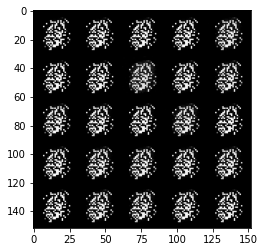

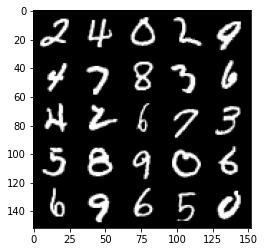

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.2217259947061538, discriminator loss: 0.4611679171025754


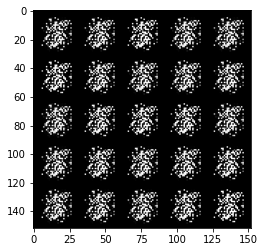

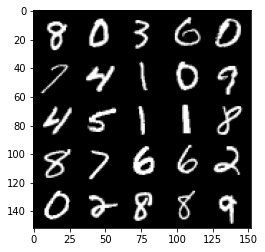

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.5514774864912015, discriminator loss: 0.3582852425724266


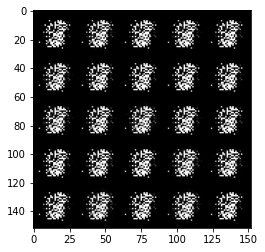

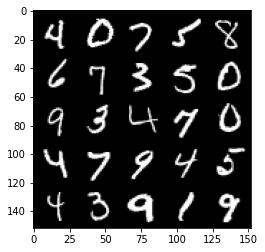

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.6988876633644117, discriminator loss: 0.2880334454774859


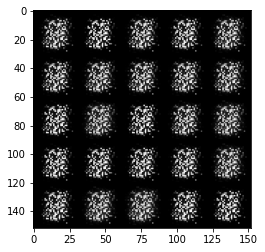

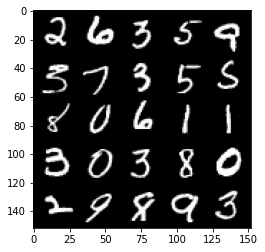

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.634357165575027, discriminator loss: 0.2545721260309222


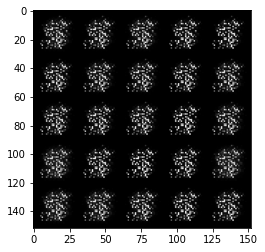

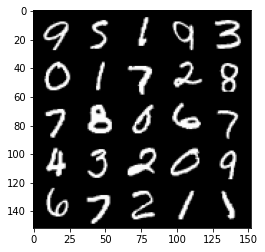

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 1.8660649454593634, discriminator loss: 0.20019424851983786


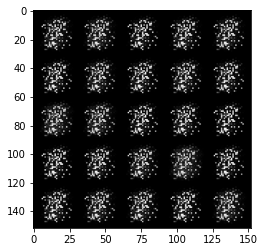

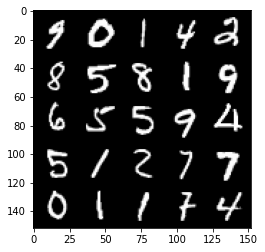

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 2.827037166595458, discriminator loss: 0.09609571178257474


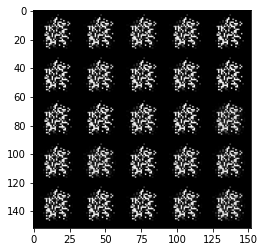

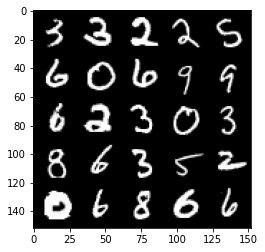

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.6416394038200464, discriminator loss: 0.042620353415608395


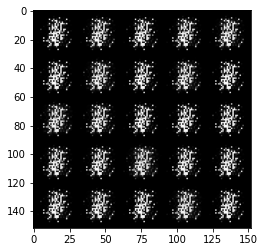

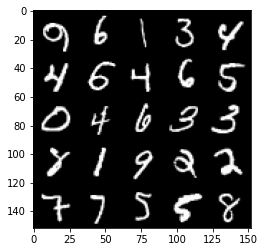

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 3.9231113414764383, discriminator loss: 0.037688542658463164


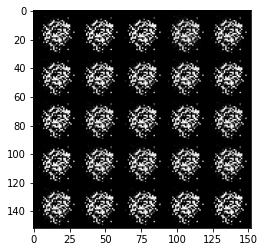

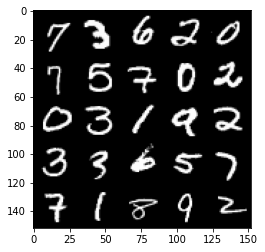

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.663411563396455, discriminator loss: 0.018089621889870615


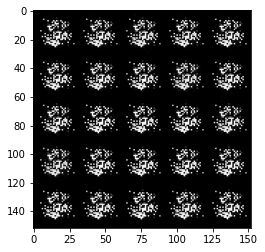

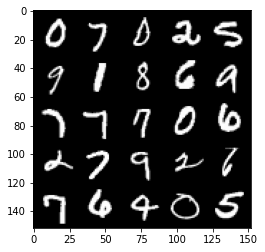

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 4.915818373680121, discriminator loss: 0.01419184561306611


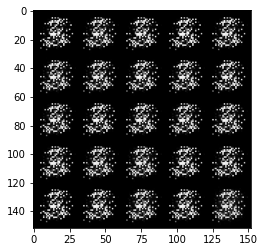

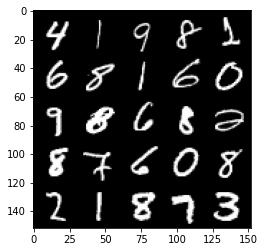

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# 1) Linear without normalization
gen = Generator(z_dim=hyperparams["z_dim"])
disc = Discriminator()
train(gen,disc,hyperparams)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.6025828158855424, discriminator loss: 0.34900680598616635


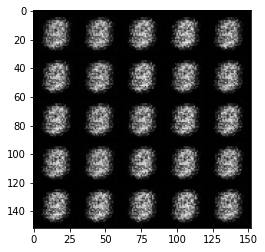

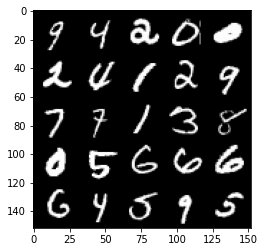

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.956413950324059, discriminator loss: 0.17924465785920618


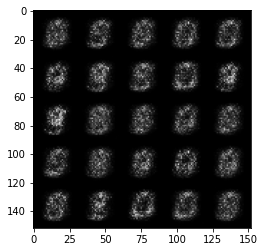

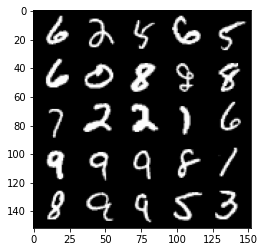

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.748940468192099, discriminator loss: 0.20761344589293


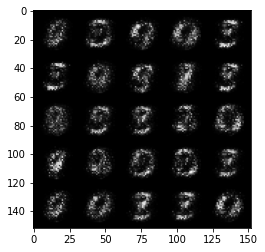

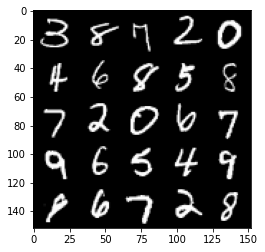

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.3112585842609414, discriminator loss: 0.15395741754025233


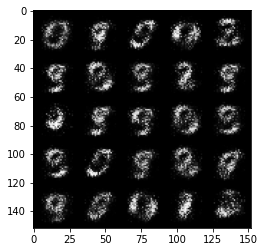

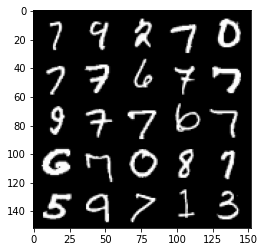

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.0696067631244683, discriminator loss: 0.09711929293349382


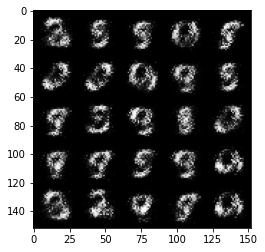

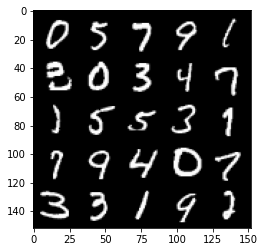

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.4574650321006786, discriminator loss: 0.08128950458765037


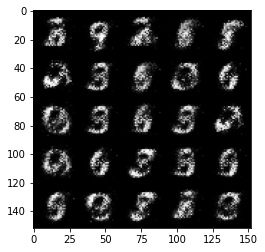

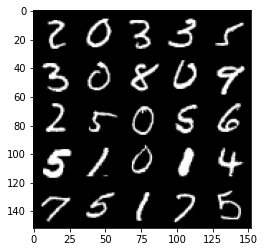

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.82989891147613, discriminator loss: 0.06550309754535562


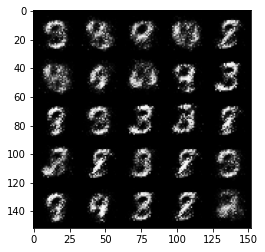

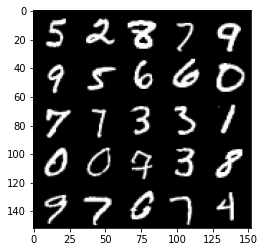

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.8271545226573953, discriminator loss: 0.07804338176548482


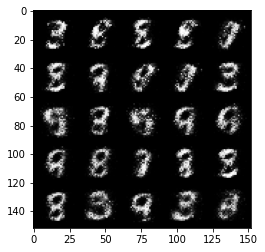

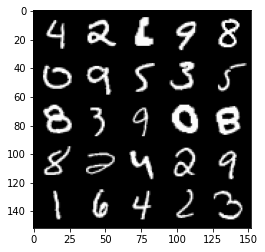

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.003961038351056, discriminator loss: 0.06521399787440893


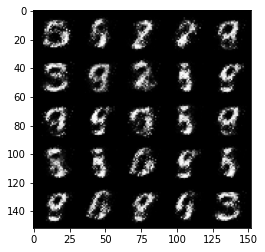

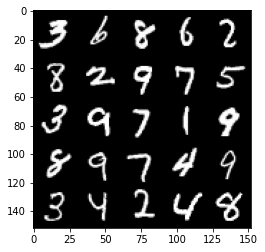

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.161727175235747, discriminator loss: 0.06336824739724393


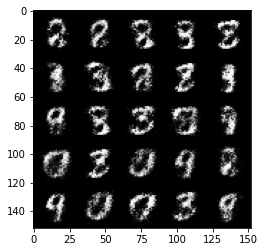

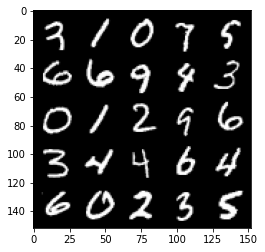

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 4.158669607877732, discriminator loss: 0.07154838425852347


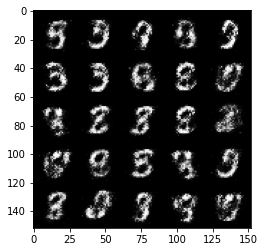

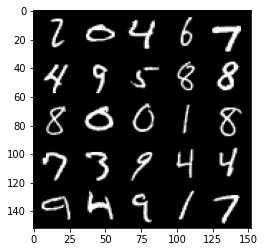

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# 2) Linear with batch normalization
hyperparams["norm"] = "batch"
gen = Generator(z_dim=hyperparams["z_dim"],normalization=hyperparams["norm"])
disc = Discriminator()
train(gen,disc,hyperparams)

In [ ]:
eps = 1e-12
class CustomSpectralNorm(nn.Module):
    def __init__(self, layer, power_iterations=1):
        super(CustomSpectralNorm, self).__init__()
        self.layer = layer
        self.power_iterations = power_iterations
        self._is_init = False

    def _update(self):
        if not self._is_init:
            self._init_params()
        w = getattr(self.layer, "weight")
        u = getattr(self.layer, "weight" + "_u")

        batch_size = w.data.shape[0]
        for _ in range(self.power_iterations):
            v = torch.mv(torch.t(w.view(batch_size,-1).data), u)
            v /= v.norm() + eps
            u = torch.mv(w.view(batch_size,-1).data, v)
            u /= u.norm() + eps

        setattr(self.layer, "weight" + "_u", u)
        sigma = torch.dot(u, torch.mv(w.view(batch_size,-1).data, v))
        w.data = w.data / sigma


    def _init_params(self):
        w = getattr(self.layer, "weight")

        batch_size = w.data.shape[0]

        u = w.data.new(batch_size).normal_(0, 1)
        u /= u.norm() + eps

        self.layer.register_buffer("weight" + "_u", u)
        self._is_init = True


    def forward(self, *args):
        self._update()
        return self.layer.forward(*args)

In [ ]:
class ConvGenerator(nn.Module):
    """
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
        normalization: what normalization technique to use for generator
    """
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64, normalization="batch"):
        super(ConvGenerator, self).__init__()
        self.z_dim = z_dim
        self.norm = normalization
        self.gen = nn.Sequential(
            self._get_generator_block(z_dim, hidden_dim * 4),
            self._get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self._get_generator_block(hidden_dim * 2, hidden_dim),
            self._get_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def _get_generator_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        """
        Function to return a sequence of operations corresponding to a generator, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        """
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        """
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        """
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        """
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        """
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [ ]:
class ConvDiscriminator(nn.Module):
    """
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
        normalization: what normalization technique to use 
    """
    def __init__(self, im_chan=1, hidden_dim=16, normalization="batch"):
        super(ConvDiscriminator, self).__init__()
        self.norm = normalization
        self.disc = nn.Sequential(
            self._get_discriminator_block(im_chan, hidden_dim),
            self._get_discriminator_block(hidden_dim, hidden_dim * 2),
            self._get_discriminator_block(hidden_dim * 2, 1, final_layer=True),
        )

    def _get_discriminator_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        """
        Function to return a sequence of operations corresponding to a discriminator block, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        """
        if not final_layer:
            if self.norm == "custom_spectral":
              return nn.Sequential(
                CustomSpectralNorm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.LeakyReLU(0.2, inplace=True)
            )
            elif self.norm == "spectral":
              return nn.Sequential(
                  nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                  nn.LeakyReLU(0.2, inplace=True)
              )
            else:
              return nn.Sequential(
                  nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                  nn.BatchNorm2d(output_channels),
                  nn.LeakyReLU(0.2, inplace=True)
              )

        else:
            if self.norm == "custom_spectral":
              return nn.Sequential(
                  CustomSpectralNorm(nn.Conv2d(input_channels, output_channels, kernel_size, stride))
              )
            elif self.norm == "spectral":
              return nn.Sequential(
                  nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride))
              )
            else:
              return nn.Sequential(
                  nn.Conv2d(input_channels, output_channels, kernel_size, stride)
              )

    def forward(self, image):
        """
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        """
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
hyperparams = {
  "n_epochs" : 25,
  "z_dim" : 64,
  "display_step" : 1000,
  "batch_size" : 128,
  "lr" : 0.0002,
  "beta1" : 0.5,
  "beta2" : 0.999,
}

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 1.3561566904187208, discriminator loss: 0.4152734077796344


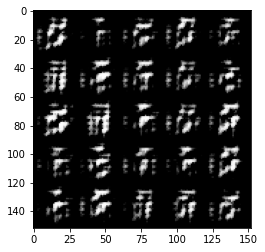

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


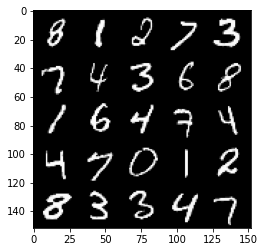

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 1.1117139871716493, discriminator loss: 0.5355975572466848


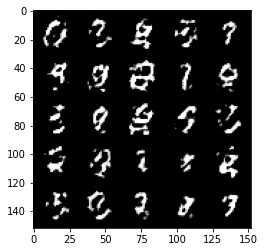

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


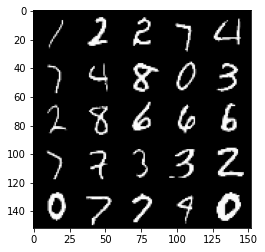

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 0.8503255711495878, discriminator loss: 0.6170226988792422


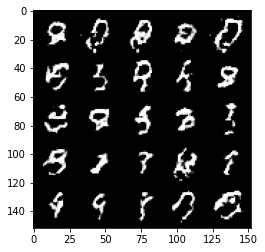

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


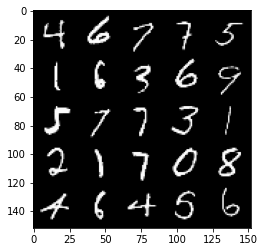

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 0.8143746811747542, discriminator loss: 0.6392857425808898


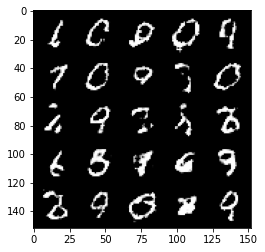

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


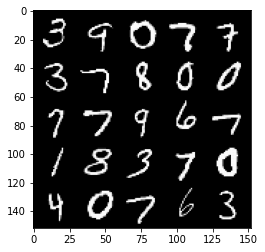

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 0.7876217186152931, discriminator loss: 0.6587167409658431


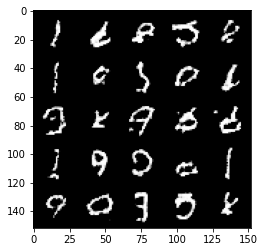

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


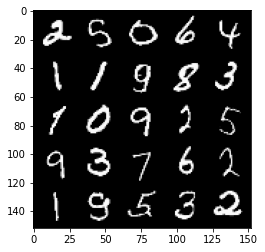

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 0.7747625591158884, discriminator loss: 0.664442921817303


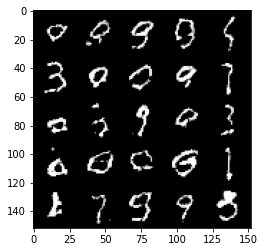

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


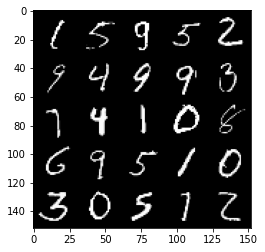

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 0.7652024030387402, discriminator loss: 0.6717482568025586


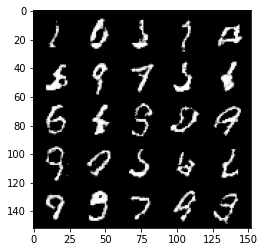

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


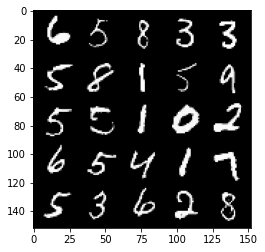

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 0.7513046607375135, discriminator loss: 0.6795717502832415


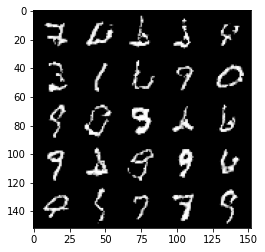

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


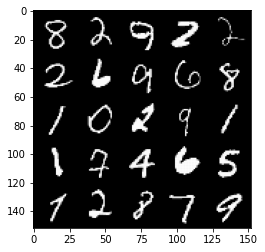

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 0.7430632603764538, discriminator loss: 0.6845123048424717


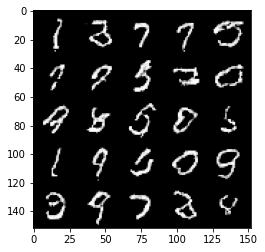

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


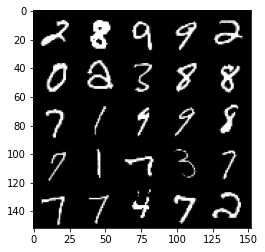

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: 0.73574353274703, discriminator loss: 0.6860673430562017


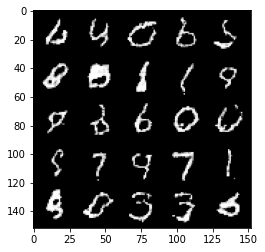

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


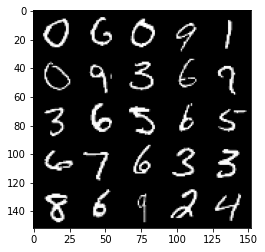

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: 0.7285886409580705, discriminator loss: 0.6877704683542246


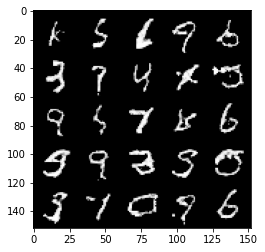

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


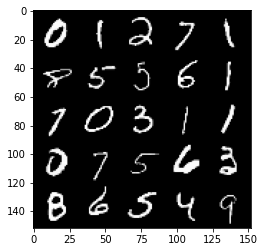

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# 3) CNN GAN with 2D Batchnorm
hyperparams["norm"] = "batch"
gen = ConvGenerator(z_dim=hyperparams["z_dim"])
disc = ConvDiscriminator(normalization="batch")
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
train(gen,disc,hyperparams,net_type="conv")

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.8681602542996418, discriminator loss: 0.2070931253805757


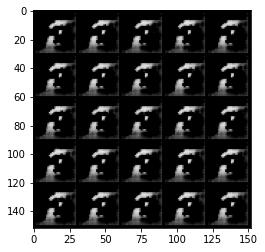

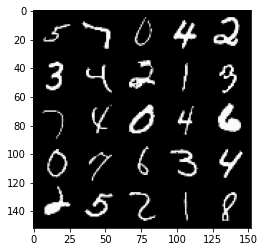

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.1563436058759702, discriminator loss: 0.48555427834391607


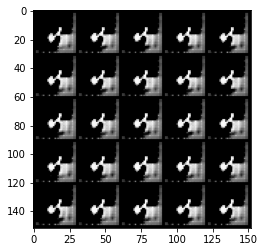

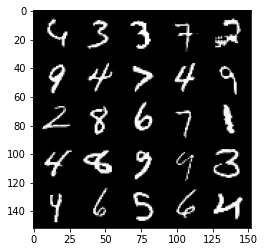

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.0372148699760417, discriminator loss: 0.5571309971809383


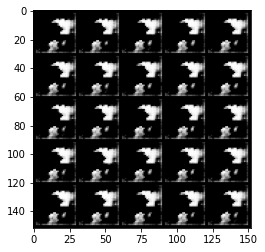

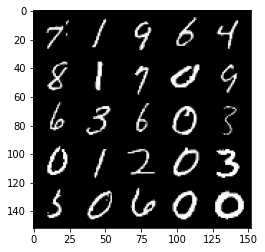

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.1146193664073945, discriminator loss: 0.5240339504927395


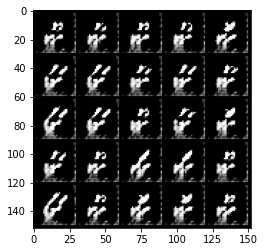

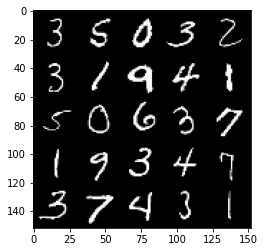

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# This is an expiremnt with Pytorch ready-made SpectralNorm
# This experiement's goal is to compare the results to the custom-made function
hyperparams["norm"] = "spectral"
gen = ConvGenerator(z_dim=hyperparams["z_dim"])
disc = ConvDiscriminator(normalization="spectral")
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
train(gen,disc,hyperparams,net_type="conv")

In [ ]:
# 4) CNN with the custom Spectral Normalization
hyperparams["norm"] = "custom_spectral"
gen = ConvGenerator(z_dim=hyperparams["z_dim"],normalization=hyperparams["norm"])
disc = ConvDiscriminator(normalization="custom_spectral")
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
train(gen,disc,hyperparams,net_type="conv")